# Amazu CTR 编码哈希特征GBDT

In [1]:
#首先 import 必要的模块
import pandas as pd
import numpy as np
import random

import lightgbm as lgbm
from lightgbm.sklearn import LGBMClassifier

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

## 1、准备数据

### 1.1 读取数据

In [2]:
# 数据路径
dpath = './data/'

filename = 'train_lb_hash.csv'
train = pd.read_csv(dpath + filename, dtype={'id':str})

In [3]:
train.head()

,id,click,C1,banner_pos,site_category,app_category,device_type,device_conn_type,C15,C16,...,Hash_101,Hash_102,Hash_103,Hash_104,Hash_105,Hash_106,Hash_107,Hash_108,Hash_109,Hash_110
0,10014385711019128754,0,1005,0,1,0,1,0,320,50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0
1,10019341288757450780,0,1005,0,1,0,1,0,320,50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0
2,10024331030544393307,1,1002,0,5,0,0,0,320,50,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,-2.0
3,10065138335302585931,0,1005,0,5,18,1,2,320,50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0
4,10077489368961027234,0,1005,0,5,4,1,0,320,50,...,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,-2.0,0.0,-2.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 123 entries, id to Hash_110
dtypes: float64(110), int64(12), object(1)
memory usage: 469.2+ MB


In [5]:
# 为了缩小数据大小，改变列的数据类型
# 独热列名
columns_onehot = train.columns[2: 13]

# 哈希列名
columns_hash = train.columns[13: 123]

# 独热编码列数据类型改为int8
train[columns_onehot] = train[columns_onehot].astype(np.int8)

# 哈希编码列数据类型改为float16
train[columns_hash] = train[columns_hash].astype(np.float16)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 123 entries, id to Hash_110
dtypes: float16(110), int64(1), int8(11), object(1)
memory usage: 117.8+ MB


### 1.2 数据分类

In [6]:
ID = train['id']
y_train = train['click']
X_train = train.drop(['id', 'click'], axis=1)

#保存特征名字以备后用
feat_names = X_train.columns

#sklearn的学习器大多之一稀疏数据输入，模型训练会快很多
#查看一个学习器是否支持稀疏数据，可以看fit函数是否支持: X: {array-like, sparse matrix}.
#可自行用timeit比较稠密数据和稀疏数据的训练时间
from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train)

## 2、LightGBM超参数调优

In [7]:
MAX_ROUNDS = 10000

In [8]:
# 相同的交叉验证分组
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

### 2.1 n_estimators

In [9]:
#直接调用lightgbm内嵌的交叉验证(cv)，可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证，且速度相对较慢
def get_n_estimators(params , X_train , y_train , early_stopping_rounds=10):
    lgbm_params = params.copy()
#    lgbm_params['num_class'] = 2
     
    lgbmtrain = lgbm.Dataset(X_train , y_train )
     
    #num_boost_round为弱分类器数目，下面的代码参数里因为已经设置了early_stopping_rounds
    #即性能未提升的次数超过过早停止设置的数值，则停止训练
    cv_result = lgbm.cv(lgbm_params , lgbmtrain , num_boost_round=MAX_ROUNDS , nfold=5,  metrics='auc' , early_stopping_rounds=early_stopping_rounds,seed=3 )
     
    print('best n_estimators:' , len(cv_result['auc-mean']))
    print('best cv score:' , cv_result['auc-mean'][-1])
     
    return len(cv_result['auc-mean'])

In [10]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'num_leaves': 20,
          'max_depth': 6,
          'learning_rate': 0.1,
          'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
          'n_jobs': 4,
          'max_bin': 127 #2^6,原始特征为整数，很少超过100
         }

n_estimators_1 = get_n_estimators(params , X_train , y_train)

best n_estimators: 730
best cv score: 0.7333707010179481


### 2.2 max_depth

In [11]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'num_leaves':20,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

max_depth_s = range(5,20) 
tuned_parameters = dict( max_depth = max_depth_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 31.9min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 36.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7, importance_type='split', learning_rate=0.1,
        max_bin=127, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=730,
        n_jobs=4, num_leaves=20, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': range(5, 20)}, pre_dispatch='2*n_jobs',
       refit=False, return_train_score='warn', scoring='neg_log_loss',
       verbose=5)

In [18]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.4034005649421068
{'max_depth': 6}


C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


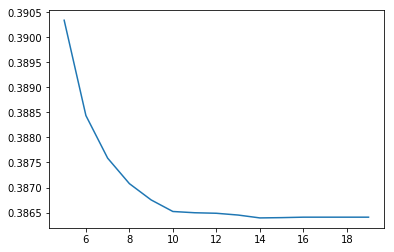

In [21]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = max_depth_s

plt.plot(x_axis, -train_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

In [29]:
max_depth_1 = list(grid_search.best_params_.values())[0]
#max_depth_1 = 14

### 2.3 num_leaves

In [30]:
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

num_leaves_s = range(10,90,10) 
tuned_parameters = dict( num_leaves = num_leaves_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 22.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7, importance_type='split', learning_rate=0.1,
        max_bin=127, max_depth=30, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=730,
        n_jobs=4, num_leaves=31, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'num_leaves': range(10, 90, 10)},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

In [31]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.40343196662895775
{'num_leaves': 30}


C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


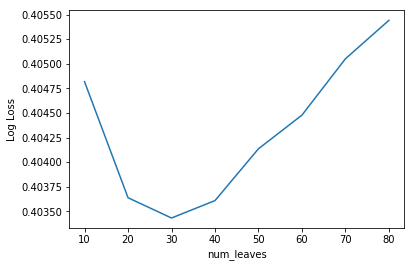

In [32]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

n_leafs = len(num_leaves_s)

x_axis = num_leaves_s
plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_means, yerr=test_stds,label = ' Test')
#plt.errorbar(x_axis, -train_means, yerr=train_stds,label = ' Train')
plt.xlabel( 'num_leaves' )
plt.ylabel( 'Log Loss' )
plt.show()

In [33]:
num_leaves_1 = list(grid_search.best_params_.values())[0]

### 2.4 min_data_in_leaf

In [34]:
params = {'boosting_type': 'gbdt',
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': 0.7,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

min_data_in_leaf_s = range(10,30,1) 
tuned_parameters = dict( min_data_in_leaf = min_data_in_leaf_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 35.4min
C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 54.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7, importance_type='split', learning_rate=0.1,
        max_bin=127, max_depth=30, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=730,
        n_jobs=4, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'min_data_in_leaf': range(10, 30)},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

In [35]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.40323601316572255
{'min_data_in_leaf': 27}


C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


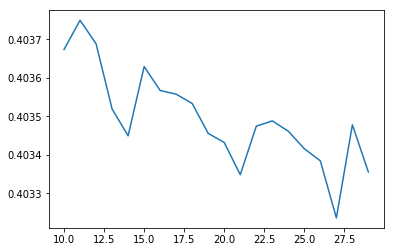

In [36]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = min_data_in_leaf_s

plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_scores, yerr=test_stds ,label = ' Test')
#plt.errorbar(x_axis, -train_scores, yerr=train_stds,label =  +' Train')

plt.show()

In [37]:
min_data_in_leaf_1 = list(grid_search.best_params_.values())[0]

### 2.5 sub_samples/bagging_fraction

In [38]:
params = {'boosting_type': 'gbdt',
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'min_data_in_leaf':min_data_in_leaf_1,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

subsample_s = [i/10.0 for i in range(5,11)]
tuned_parameters = dict( subsample = subsample_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 15.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 15.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7, importance_type='split', learning_rate=0.1,
        max_bin=127, max_depth=30, min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=27, min_split_gain=0.0,
        n_estimators=730, n_jobs=4, num_leaves=30, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

In [39]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.4029852638192467
{'subsample': 0.9}


C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


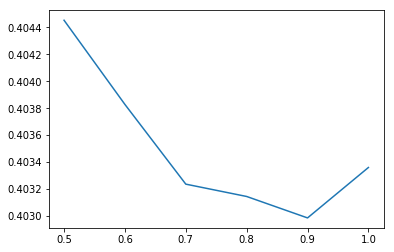

In [40]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = subsample_s

plt.plot(x_axis, -test_means)
plt.show()

In [41]:
subsample_1 = list(grid_search.best_params_.values())[0]

### 2.6 sub_feature/feature_fraction/colsample_bytree

In [42]:
params = {'boosting_type': 'gbdt',
          'n_jobs': 4,
          'learning_rate': 0.1,
          'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'min_data_in_leaf':min_data_in_leaf_1,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': subsample_1,
          'bagging_freq': 1,
          'colsample_bytree': 0.7,
         }
lg = LGBMClassifier(silent=False,  **params)

colsample_bytree_s = [i/10.0 for i in range(1,11)]
tuned_parameters = dict( colsample_bytree = colsample_bytree_s)

grid_search = GridSearchCV(lg, n_jobs=4,  param_grid=tuned_parameters, cv = kfold, scoring="neg_log_loss", verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 25.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7, importance_type='split', learning_rate=0.1,
        max_bin=127, max_depth=30, min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=27, min_split_gain=0.0,
        n_estimators=730, n_jobs=4, num_leaves=30, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=0.9, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

In [43]:
# examine the best model
print(-grid_search.best_score_)
print(grid_search.best_params_)

0.40288316993096673
{'colsample_bytree': 1.0}


C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Nick\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


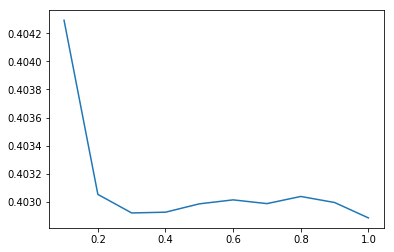

In [44]:
# plot CV误差曲线
test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = colsample_bytree_s

plt.plot(x_axis, -test_means)
#plt.errorbar(x_axis, -test_scores[:,i], yerr=test_stds[:,i] ,label = str(max_depths[i]) +' Test')
#plt.errorbar(x_axis, -train_scores[:,i], yerr=train_stds[:,i] ,label = str(max_depths[i]) +' Train')

plt.show()

In [45]:
colsample_bytree_1 = list(grid_search.best_params_.values())[0]

### 2.7 减小学习率，调整n_estimators

In [46]:
params = {'boosting_type': 'gbdt',
          'n_jobs': 4,
          'learning_rate': 0.01,
          #'n_estimators':n_estimators_1,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'min_data_in_leaf':min_data_in_leaf_1,
          'min_child_samples':18,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': subsample_1,
          'bagging_freq': 1,
          'colsample_bytree': colsample_bytree_1
         }
n_estimators_2 = get_n_estimators(params , X_train , y_train)

best n_estimators: 4958
best cv score: 0.7345502507718695


### 2.8 用所有训练数据，采用最佳参数重新训练模型

In [47]:
params = {'boosting_type': 'gbdt',
          'n_jobs': 4,
          'learning_rate': 0.01,
          'n_estimators':n_estimators_2,
          'max_depth': max_depth_1,
          'num_leaves':num_leaves_1,
          'min_child_samples':min_data_in_leaf_1,
          'max_bin': 127, #2^6,原始特征为整数，很少超过100
          'subsample': subsample_1,
          'bagging_freq': 1,
          'colsample_bytree': colsample_bytree_1,
         }

lg = LGBMClassifier(silent=False,  **params)
lg.fit(X_train, y_train)

LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
        max_bin=127, max_depth=30, min_child_samples=27,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=4958,
        n_jobs=4, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=0.9,
        subsample_for_bin=200000, subsample_freq=0)

## 3、保存模型，用于后续测试

In [48]:
import pickle

pickle.dump(lg, open("Train_Lb_Hash_LightGBM.pkl", 'wb'))

In [49]:
df = pd.DataFrame({"columns":list(feat_names), "importance":list(lg.feature_importances_.T)})
df = df.sort_values(by=['importance'],ascending=False)

In [50]:
df

,columns,importance
10,C21,6670
9,C19,4489
71,Hash_61,3539
72,Hash_62,3233
81,Hash_71,3216
78,Hash_68,3075
2,site_category,2851
92,Hash_82,2816
82,Hash_72,2660
3,app_category,2610


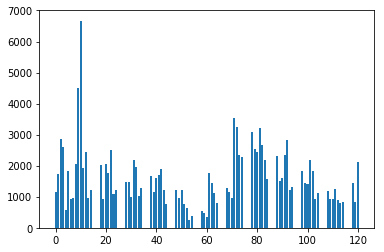

In [51]:
plt.bar(range(len(lg.feature_importances_)), lg.feature_importances_)
plt.show()

## 4、保存结果

### 4.1 预测叶子节点

In [52]:
lgb_leaves = lg.predict(X_train, pred_leaf=True)
print(lgb_leaves)

MemoryError: 

In [64]:
lgb_leaves.shape

NameError: name 'lgb_leaves' is not defined

### 4.2 保存结果作为新的训练集

In [ ]:
# 生成提交结果
out_df = pd.DataFrame(lgb_leaves)

columns = np.empty(lgb_leaves.shape[1], dtype=object)
for i in range(lgb_leaves.shape[1]):
    columns[i] = 'Class_' + str(i+1)
    
out_df.columns = columns

out_df.head()

In [ ]:
# 连接id和click
out_df = pd.concat([ID, y_train, out_df], axis=1, ignore_index=True)

In [ ]:
# 设置输出数据列名
names_1 = ['id', 'click']
names_2 = columns
out_feat_names = []
out_feat_names.extend(names_1)
out_feat_names.extend(names_2)

out_df.columns = out_feat_names
out_df.head()

In [ ]:
# 转为csv格式保存
out_df.to_csv(dpath + "train_oh_hash_GBDT.csv", index=False, header=True)